In [102]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import seaborn as sns
%matplotlib inline

from ipywidgets import interactive
import ipywidgets as widgets

# Introduction to Linear Regression

This is to follow the book: http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf

* Is there a relationship between advertising budget and sales?
* How strong is the relationship between advertising budget and sales?
* Which media contribute to sales?
* How accurately can we estimate the effect of each medium on sales?
* How accurately can we predict future sales?
* Is the relationship linear?
* Is there synergy among the advertising media?

$y \approx \beta_0+\beta_1*X$

$\hat{y} = \hat{\beta}_0+\hat{\beta}_1*X$

In [107]:
df = pd.read_csv(r'C:\Users\anton.bezuglov\Documents\notebooks\data200_notebooks\data\Advertising.csv')
df.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


## Estimating the coefficients

Mean Squared Error approach -- minimize the average squared difference between a point and linear regression.

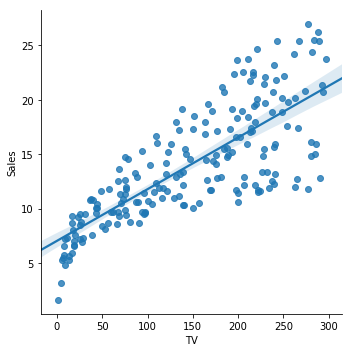

In [108]:
sns.lmplot(x = 'TV', y = 'Sales', data = df)

Experiment with the coefficients below to minimize RSS:

In [110]:
X = df['TV']
y = df['Sales']

In [111]:
def linear_fit(b0,b1):
    y_hat = b0+b1*X
    RSS = np.sum((y_hat-y)**2)
    
    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(1,2,1)
    ax.plot(X, y_hat, label = '$\hat{y}$', color = 'b')
    ax.scatter(X, y, label = 'Sales')
    ax.set_xlabel('TV')
    ax.set_ylabel('Sales')
    ax.set_title('RSS = %.2f'%RSS)
    ax.legend()
    
    ax = fig.add_subplot(1,2,2)
    sns.distplot(y_hat-y, ax = ax)
    ax.set_title('Error Distribution')
    ax.set_xlabel('$\hat{y}-y$')
    plt.show()
    
i_plot = interactive(linear_fit, b1 = (0.0,0.1,0.005), b0 = (0.0,10.0))
i_plot

interactive(children=(FloatSlider(value=5.0, description='b0', max=10.0), FloatSlider(value=0.05, description=…

According to the least squares approach, the equations for $\hat{\beta}_1$ and $\hat{\beta}_0$ are: 

$\hat{\beta}_1 = \frac{\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})}{\sum_{i=1}^{n}(x_i-\bar{x})^2}$

$\hat{\beta}_0 = \bar{y}-\hat{\beta}_1\bar{x}$

In [112]:
def least_squares_estimate(X,y):
    b1_hat = np.sum((X-np.mean(X))*(y-np.mean(y)))/np.sum((X-np.mean(X))**2)
    b0_hat = np.mean(y)-b1_hat*np.mean(X)
    return b0_hat, b1_hat

least_squares_estimate(X,y)

(7.032593549127698, 0.047536640433019736)

## Assessing the Accuracy of the Coefficients

The assumption is that the *true* relationship between X and y takes the form $y = f(X)+\epsilon$, where $\epsilon$ is a mean-zero random error term:

$y = \beta_0+\beta_1X+\epsilon$

Let us illustrate this with simulated data:

In [113]:
X = np.arange(-2,2,0.05)
y = 2 + 3*X + np.random.normal(0,5,X.shape)

b0_hat, b1_hat = least_squares_estimate(X,y)

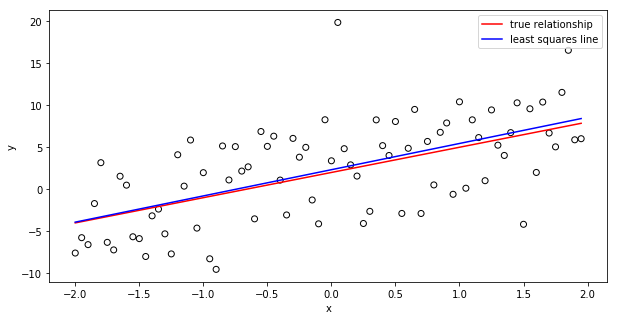

In [115]:
plt.figure(figsize = (10,5))
plt.scatter(X,y,facecolors='none', edgecolors='black', 
            color = 'black')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(X,2+3*X, color = 'red', label = 'true relationship')
plt.plot(X,b0_hat+b1_hat*X, color = 'blue', label = 'least squares line')
plt.legend()
plt.show()

At this time, let us compute $\beta_0$ and $\beta_1$ based on sample of data:

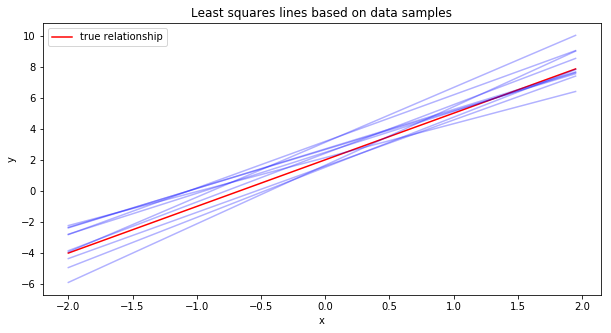

In [151]:
betas = []
num_tries = 10 # number of estimates
for _ in range(num_tries):
    indices = np.random.choice(X.shape[0]
                               ,size = round(0.4*X.shape[0]) # 0.4 -- sample size, 40% of the data
                               ,replace = False )
    betas.append(least_squares_estimate(X[indices],y[indices]))

plt.figure(figsize = (10,5))
plt.xlabel('x')
plt.ylabel('y')
plt.plot(X,2+3*X, color = 'red', label = 'true relationship')
for (b0_hat,b1_hat) in betas:
    plt.plot(X,b0_hat+b1_hat*X, color = 'blue', alpha = 0.3)
plt.title('Least squares lines based on data samples')
plt.legend()
plt.show()

The standard errors of $\beta_0$ and $\beta_1$ are as follows:

$SE(\hat{\beta}_0)^2 = \sigma^2\left[1/n+\frac{\bar{x}^2}{\sum_{i=1}^n\left(x_i-\bar{x}\right)^2}\right]$

$SE(\hat{\beta}_1)^2 = \frac{\sigma^2}{\sum_{i=1}^n\left(x_i-\bar{x}\right)^2}$

where $\sigma^2 = Var(\epsilon)$ that can be estimated as residual standard error (RSE):

$\sigma = RSE = \sqrt{RSS/(n-2)}$

95% confidence intervals are:
$\left[\hat{\beta}_0-2*SE(\hat{\beta}_0),\hat{\beta}_0+2*SE(\hat{\beta}_0)\right]$

$\left[\hat{\beta}_1-2*SE(\hat{\beta}_1),\hat{\beta}_1+2*SE(\hat{\beta}_1)\right]$

In [214]:
def standard_errors(betas):
    b0_hat, b1_hat = betas[0], betas[1]
    y_hat = b0_hat+b1_hat*X
    var_e = np.std(y_hat-y)**2
    RSS = np.sum((y_hat-y)**2)
    var_e = RSE_squared = (RSS/(X.shape[0]-2))
    SE_b0 = (var_e*(1/X.shape[0]+np.mean(X)**2/np.sum((X-np.mean(X))**2)))**0.5
    SE_b1 = (var_e/np.sum((X-np.mean(X))**2))**0.5
    return SE_b0, SE_b1

betas = least_squares_estimate(X,y)
SE = standard_errors(betas)
print(SE)
print("Beta 95% confidence intervals: ")
print("\tBeta 0: [%.3f,%.3f]"%(betas[0]-2*SE[0],betas[0]+2*SE[0]))
print("\tBeta 1: [%.3f,%.3f]"%(betas[1]-2*SE[1],betas[1]+2*SE[1]))

(0.4578429402734785, 0.0026906071877968707)
Beta 95% confidence intervals: 
	Beta 0: [6.117,7.948]
	Beta 1: [0.042,0.053]


Let us get back to our original dataset (Advertising):

In [215]:
X = df['TV']
y = df['Sales']
betas = least_squares_estimate(X,y)

print(betas)

SE = standard_errors(betas)
print(SE)

print("Beta 95% confidence intervals: ")
print("\tBeta 0: [%.3f,%.3f]"%(betas[0]-2*SE[0],betas[0]+2*SE[0]))
print("\tBeta 1: [%.3f,%.3f]"%(betas[1]-2*SE[1],betas[1]+2*SE[1]))

(7.032593549127698, 0.047536640433019736)
(0.4578429402734785, 0.0026906071877968707)
Beta 95% confidence intervals: 
	Beta 0: [6.117,7.948]
	Beta 1: [0.042,0.053]
